# Implementando uma LSTM com Grid Search para escolher melhor os parâmetros no Mapa Logístico

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

import sys 
sys.path.insert(0, '../../../scripts')

### 1.2 Bibliotecas para LSTM

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
import lstm_model as lstm

### 1.3 Bibliotecas dos sistemas caóticos

In [6]:
import timeseries as times
import logisticmap as logmap

## 2. Gerando a série temporal do mapa logístico

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original. Utilizaremos  $r = 3.86$, o que faz com que o sistema esteja em caos.

In [7]:
x_inicial = 0.5
n_inicial = 0
n_iteracoes = 5000
r=3.86
estados = np.array([x_inicial, n_inicial])

In [8]:
mapa = logmap.MapaLogistico(estado_inicial=estados, r=r)

In [9]:
for n in range(0, n_iteracoes):
    mapa.iterar()
    estados = np.vstack((estados, mapa.ler_estado()))

In [10]:
x = estados[:, 0]
n = estados[:, 1]

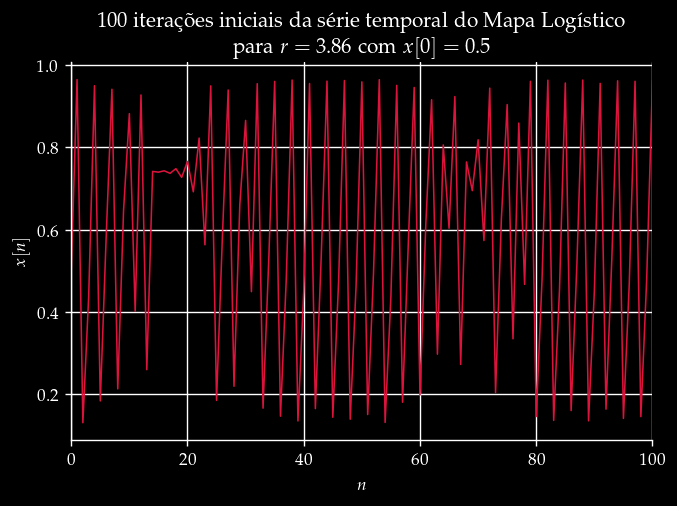

In [11]:
fig, ax = plt.subplots()
ax.plot(n, x, color='Crimson', linewidth=0.9)

ax.set_title("$100$ iterações iniciais da série temporal do Mapa Logístico\n para $r =$ " + str(r) + " com $x[0] =$ " + str(x[0]))
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(0,100)
    
ax.grid(True)
sns.despine()

plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [12]:
K = 4
L = 3
tam_teste = 0.15

In [13]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [14]:
serie_temporal.criar_matrizes()

In [15]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

### 2.2 Pré-processamento nos dados de entrada

In [16]:
len_treino = X_treino.shape[0]
len_teste = X_teste.shape[0]
n_samples = X_treino.shape[1]

In [17]:
X_treino = np.reshape(X_treino,(len_treino, n_samples, 1))
X_teste = np.reshape(X_teste,(len_teste, n_samples, 1))

## 3. Definindo o modelo para a LSTM e executando os Gridsearches

### 3.1 Criando o objeto da LSTM

In [18]:
lstm = lstm.ModeloLSTM(input_shape = (K, 1))

Utilizaremos os seguintes parâmetros no *Grid Search*:

In [19]:
param_grid = dict(batch_size=[2, 4, 8, 16, 32], 
                  activation=['selu', 'relu', 'elu', 'sigmoid', 'tanh'], 
                  init_mode = ['lecun_uniform', 'lecun_normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                  n_neurons = [5, 10, 15, 20, 30, 50, 75, 100],
                  learning_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

Para facilitar, dividiremos esse processo em etapas.

### 3.2 Definindo parâmetros que não serão definidos pelo *Grid Search*

In [20]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

### 3.3 Definindo e executando o primeiro *Grid Search*

Primeiro, avaliaremos o impacto do *batch size*.

In [21]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32])

In [22]:
model_cv_1 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0)

In [23]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [24]:
grid_result = grid.fit(X_treino, y_treino)

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.001864 using {'batch_size': 4}


In [26]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.002508 (0.002118) with: {'batch_size': 2}
-0.001864 (0.001300) with: {'batch_size': 4}
-0.023584 (0.009720) with: {'batch_size': 8}
-0.033163 (0.003129) with: {'batch_size': 16}
-0.042336 (0.003850) with: {'batch_size': 32}


### 3.4 Definindo e executando o segundo *Grid Search*

Agora, avaliaremos o impacto do *learning rate* do otimizador.

In [18]:
model_cv_2 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0, batch_size=2, batch_normalization='OFF')

In [19]:
param_grid_2 = dict(learning_rate=[0.001, 0.003, 0.005, 0.008, 0.01])

In [20]:
grid = GridSearchCV(estimator=model_cv_2, param_grid=param_grid_2, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [21]:
grid_result = grid.fit(X_treino, y_treino)

In [22]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.007609 using {'learning_rate': 0.003}


In [23]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.013338 (0.011113) with: {'learning_rate': 0.001}
-0.007609 (0.008557) with: {'learning_rate': 0.003}
-0.017000 (0.010723) with: {'learning_rate': 0.005}
-0.031569 (0.010900) with: {'learning_rate': 0.008}
-0.043478 (0.004508) with: {'learning_rate': 0.01}


### 3.5 Definindo e executando o terceiro *Grid Search*

Agora, avaliaremos o impacto da função de ativação da camada intermediária.

In [24]:
model_cv_3 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0, batch_size=2, batch_normalization='OFF', learning_rate=0.003)

In [25]:
param_grid_3 = dict(activation=['selu', 'relu', 'elu', 'sigmoid', 'tanh'])

In [26]:
grid = GridSearchCV(estimator=model_cv_3, param_grid=param_grid_3, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [27]:
grid_result = grid.fit(X_treino, y_treino)

In [28]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000939 using {'activation': 'tanh'}


In [29]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.006868 (0.002487) with: {'activation': 'selu'}
-0.001459 (0.000349) with: {'activation': 'relu'}
-0.013469 (0.011514) with: {'activation': 'elu'}
-0.000989 (0.001287) with: {'activation': 'sigmoid'}
-0.000939 (0.000318) with: {'activation': 'tanh'}


### 3.6 Definindo e executando o quarto *Grid Search*

Agora, avaliaremos o impacto do inicializador da camada intermediária.

In [30]:
model_cv_4 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0, batch_size=2, batch_normalization='OFF', learning_rate=0.003, activation='tanh')

In [31]:
param_grid_4 = dict(init_mode = ['glorot_uniform', 'glorot_normal'])

In [32]:
grid = GridSearchCV(estimator=model_cv_4, param_grid=param_grid_4, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [33]:
grid_result = grid.fit(X_treino, y_treino)

In [34]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.003020 using {'init_mode': 'glorot_uniform'}


In [35]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.003020 (0.002229) with: {'init_mode': 'glorot_uniform'}
-0.005604 (0.007977) with: {'init_mode': 'glorot_normal'}


### 3.7 Definindo e executando o quinto *Grid Search*

Agora, avaliaremos o número de neurônios na camada intermediária.

In [36]:
model_cv_5 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0, batch_size=2, batch_normalization='OFF', learning_rate=0.003, activation='tanh', init_mode='glorot_uniform')

In [37]:
param_grid_5 = dict(n_neurons = [5, 10, 15, 20, 30, 50, 75, 100])

In [38]:
grid = GridSearchCV(estimator=model_cv_5, param_grid=param_grid_5, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [39]:
grid_result = grid.fit(X_treino, y_treino)

In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.001795 using {'n_neurons': 10}


In [41]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.007413 (0.006256) with: {'n_neurons': 5}
-0.001795 (0.001840) with: {'n_neurons': 10}
-0.003611 (0.002886) with: {'n_neurons': 15}
-0.002872 (0.002484) with: {'n_neurons': 20}
-0.005684 (0.006433) with: {'n_neurons': 30}
-0.013174 (0.010937) with: {'n_neurons': 50}
-0.018582 (0.017341) with: {'n_neurons': 75}
-0.010835 (0.007711) with: {'n_neurons': 100}


### Treino com o melhor modelo

In [24]:
model = criar_modelo(name='MLP-basica-logistic', batch_normalization='OFF', learning_rate=0.003, activation='tanh', init_mode='glorot_uniform', n_neurons=10)

In [25]:
model.summary()

Model: "MLP-basica-logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_de_entrada (Dense)    (None, 4)                 20        
_________________________________________________________________
camada_intermediaria (Dense) (None, 10)                50        
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [26]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.1)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

In [28]:
batch_size = 2

In [29]:
history = model.fit(X_treino, y_treino, epochs=100,
                            callbacks=early_stopping, validation_data=(X_val, y_val),
                            batch_size=batch_size)
treinamento = pd.DataFrame(history.history)

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0572 - val_loss: 0.0504
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0439 - val_loss: 0.0492
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0428 - val_loss: 0.0434
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0405 - val_loss: 0.0468
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0392 - val_loss: 0.0403
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0367 - val_loss: 0.0380
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0350 - val_loss: 0.0365
Epoch 8/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0337 - val_loss: 0.0322
Epoch 9/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0337 - val_loss: 0.0317
Epoch 10/100
1719/1719 [==============================] - 2s 1ms/step - l

## Teste com o melhor modelo

In [30]:
y_pred = model.predict(X_teste)

### Gráfico

In [31]:
fig, ax = plt.subplots()
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_teste, color='Crimson', label='Valor real')
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_pred, color='Silver', label='MLP')

ax.set_title("Comparação da predição da MLP com o valor real do mapa logístico\n utilizando a rede neural ótima no conjunto de teste")
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(4900, 5000)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()
fig.savefig("../../../../images/mlp-basica/performance/mlp-basica-vs-logistic.png")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


### Erro Quadrático Médio

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
mse = mean_squared_error(y_teste, y_pred)
print("MSE = " + str(mse))

MSE = 0.00034681427238340606


### Salvando o Modelo

In [34]:
model.save("../../../../models/mlp-basica/mlp-basica-logistic.h5", include_optimizer=True)